# Load Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import seaborn as sns
import os
import pprint as pp
import itertools
from imblearn.over_sampling import RandomOverSampler 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from glob import glob
from tqdm import tqdm
from PIL import Image

plt.style.use("ggplot")

In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/ML/Kaggle"

In [4]:
%cd /content/drive/My Drive/ML/Kaggle

/content/drive/My Drive/ML/Kaggle


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:38<00:00, 28.4MB/s]
100% 5.20G/5.20G [01:38<00:00, 56.7MB/s]


In [ ]:
ls

 asl_alphabet_test/                      hmnist_28_28_L.csv
 asl-alphabet-test-copy2/                hmnist_28_28_RGB.csv
 asl_alphabet_train/                     hmnist_8_8_L.csv
 asl-sign-language-pictures-minus-j-z/   hmnist_8_8_RGB.csv
 asl_test/                               index.csv
 AveragePooling.h5                       index_full.csv
 data/                                   ISIC/
 dataset/                                isic.csv
 feature_extract/                        kaggle.json
 ham10000_images_part_1/                 logs/
 HAM10000_images_part_1/                 model.png
 ham10000_images_part_2/                 paths.pkl
 HAM10000_images_part_2/                'Untitled Folder 1'/
 HAM10000_metadata.csv                   vectors.pkl


In [ ]:
!unzip \*.zip &> /dev/null && rm *.zip

In [5]:
base_skin_dir = os.path.join('..', '/content/drive/MyDrive/ML/Kaggle')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [6]:
data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML/Kaggle/data/ISIC_002...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML/Kaggle/data/ISIC_002...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML/Kaggle/data/ISIC_002...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML/Kaggle/data/ISIC_002...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/ML/Kaggle/data/ISIC_003...,Benign keratosis-like lesions,2


# EDA

In [7]:
data.describe()

,age,cell_type_idx
count,9958.000000,10015.000000
mean,51.863828,3.623964
std,16.968614,1.208859
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


In [8]:
data.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [9]:
rata_umur = data['age'].mean()
data['age'] = data['age'].fillna(rata_umur)
data.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            10015 non-null  float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [11]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     
                        n_samples=7000,   
                        random_state=123) 

        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

In [12]:
def load_img_data(size, df, balanced=False):
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)
    
    return imgs, df['cell_type_idx'].values

In [13]:
imgs, target   = load_img_data(32, data, balanced=False)

100%|██████████| 10015/10015 [06:32<00:00, 25.54it/s]


(10015, 32, 32, 3)


# Resampling

In [14]:
Label = data["cell_type_idx"]
Data = data.drop(columns=["cell_type_idx"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


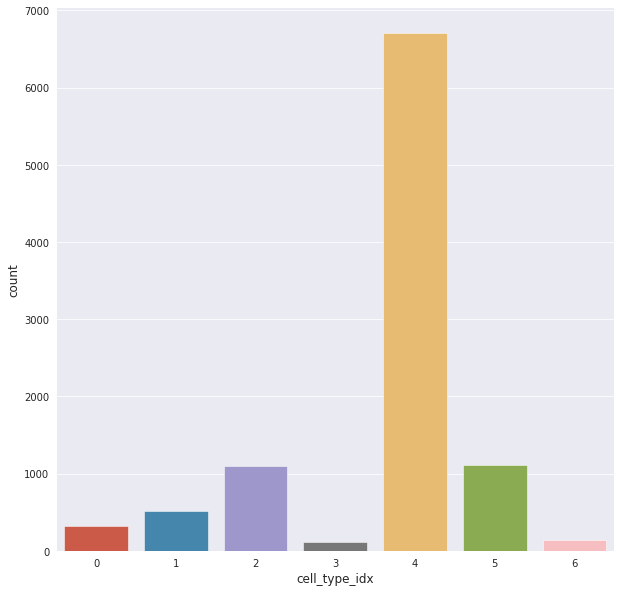

In [15]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(Label)

In [16]:
oversample = RandomOverSampler()
Data,Label  = oversample.fit_resample(Data,Label)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


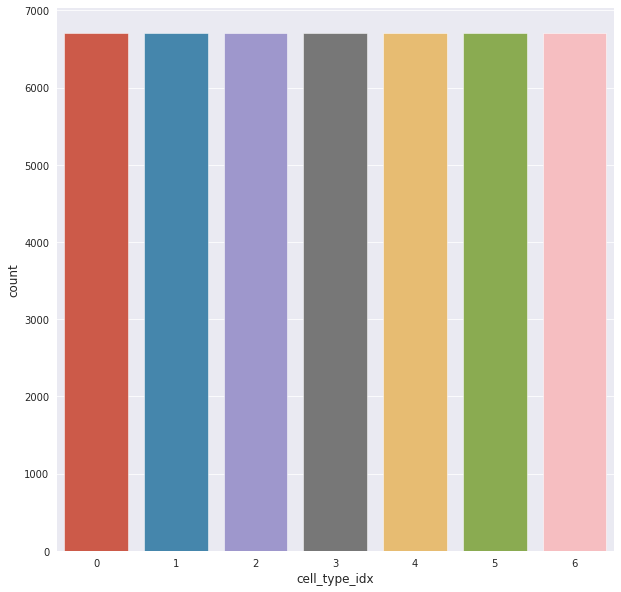

In [17]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(Label)

In [18]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6], dtype=int8)

In [19]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

# Splitting

In [20]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.01)
x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.19)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape , y_train.shape , y_val.shape , y_test.shape]

[(8112, 32, 32, 3),
 (1903, 32, 32, 3),
 (101, 32, 32, 3),
 (8112,),
 (1903,),
 (101,)]

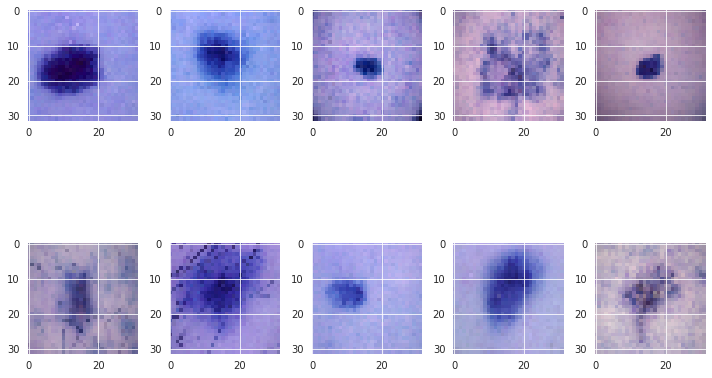

In [21]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(32,32,3))
        k = k + 1
    plt.tight_layout()

In [22]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [23]:
print(y_train)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [24]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)
testgen = ImageDataGenerator(rescale=(1./255))

# Model 1

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.0001
                                            , decay=0.001/32 )

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalMaxPooling2D, concatenate
from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB5, VGG16
from tensorflow.keras.optimizers import Adam

In [27]:
inputan = (32,32,3)
input_model = Input(shape=inputan)

vgg_model = VGG16(include_top=False, weights="imagenet", input_shape=inputan)(input_model)

def pemodelan(m1):
  model = concatenate([m1])
  model = GlobalMaxPooling2D()(model)
  model = Flatten(name="flatten")(model)
  model = Dense(2048, activation="relu")(model)
  model = Dropout(0.35)(model)
  model = Dense(1024, activation="relu")(model)
  model = Dropout(0.35)(model)
  model = Dense(7, activation="softmax")(model)

  return model

58900480/58889256 [==============================] - 1s 0us/step


In [28]:
model1= pemodelan(vgg_model)
pemodelan_1 = Model(inputs=input_model, outputs=model1)
pemodelan_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 concatenate (Concatenate)   (None, 1, 1, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                             

In [29]:
vgg_model.trainable = False

In [30]:
import tensorflow as tf
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='./logs/aug')

In [31]:
%load_ext tensorboard

In [32]:
!rm -rf ./logs/aug

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def callback(path):
  checkpoint_callback = ModelCheckpoint(path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
  reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0001, verbose=1)
  callbacks_list = [checkpoint_callback, reduce_callback]
  return callbacks_list

In [34]:
best_model_path = 'model1.h5'
cb=callback(best_model_path)

In [35]:
learning_rate=0.0001
pemodelan_1.compile(optimizer=Adam(lr=learning_rate), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
history = pemodelan_1.fit(x_train ,
                    y_train ,
                    epochs=100 ,
                    batch_size=128,
                    validation_data=(x_test , y_test) ,
                    callbacks=[tensorboard,cb])

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 1.0366 - accuracy: 0.6605
Epoch 00001: val_accuracy improved from -inf to 0.69307, saving model to model1.h5
64/64 [==============================] - 29s 214ms/step - loss: 1.0366 - accuracy: 0.6605 - val_loss: 0.8916 - val_accuracy: 0.6931 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.7000
Epoch 00002: val_accuracy improved from 0.69307 to 0.72277, saving model to model1.h5
64/64 [==============================] - 9s 147ms/step - loss: 0.8270 - accuracy: 0.7000 - val_loss: 0.7826 - val_accuracy: 0.7228 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.7219
Epoch 00003: val_accuracy improved from 0.72277 to 0.77228, saving model to model1.h5
64/64 [==============================] - 9s 144ms/step - loss: 0.7631 - accuracy: 0.7219 - val_loss: 0.6989 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 4/100
64/

In [37]:
pemodelan_1.evaluate(x_test , y_test)

4/4 [==============================] - 1s 111ms/step - loss: 0.2273 - accuracy: 0.9604


[0.22726348042488098, 0.9603960514068604]

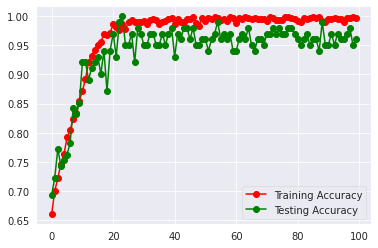

In [38]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

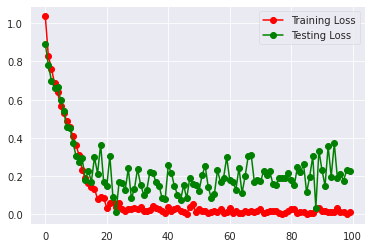

In [39]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [40]:
y_pred  = pemodelan_1.predict(x_test).round()

In [41]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       1.00      1.00      1.00         2
                             ('bcc', ' basal cell carcinoma')       0.75      1.00      0.86         6
                     ('bkl', 'benign keratosis-like lesions')       1.00      1.00      1.00        13
                                     ('df', 'dermatofibroma')       1.00      0.75      0.86         4
                                  ('nv', ' melanocytic nevi')       0.98      0.97      0.98        66
              ('vasc', ' pyogenic granulomas and hemorrhage')       1.00      0.88      0.93         8
                                          ('mel', 'melanoma')       1.00      1.00      1.00         2

                                                    micro avg       0.97      0.96      0.97       101
                                                    macro avg       0.9

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


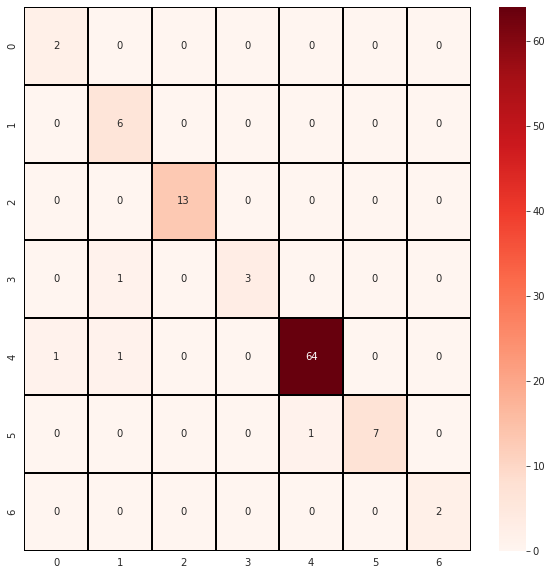

In [45]:
cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [46]:
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((32,32))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Path : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

data_folder = "/content/drive/MyDrive/ML/Kaggle/data"

model = pemodelan_1

vectors = []
paths = []

for image_path in os.listdir(data_folder):
    image_path_full = os.path.join(data_folder, image_path)
    image_vector = extract_vector(model,image_path_full)
    vectors.append(image_vector)
    paths.append(image_path_full)

vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors, open(vector_file, "wb"))
pickle.dump(paths, open(path_file, "wb"))

Streaming output truncated to the last 5000 lines.
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028339.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028313.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028274.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028309.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028311.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028306.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028279.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028321.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028329.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028383.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028402.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028394.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028378.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028384.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028411.jpg
Path

# Predict

Dataset :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0033367.jpg


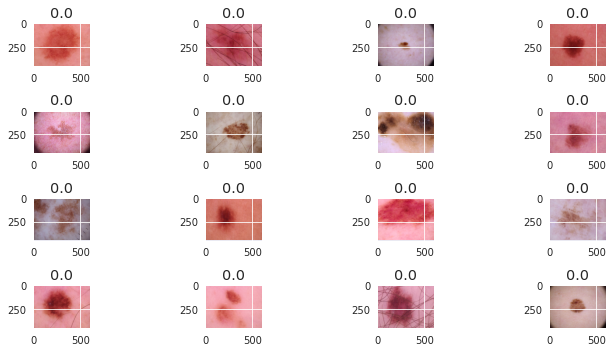

In [47]:
import math
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((32,32))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Dataset : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

search_image = "/content/drive/MyDrive/ML/Kaggle/data/ISIC_0033367.jpg"

model = pemodelan_1

search_vector = extract_vector(model, search_image)

vectors = pickle.load(open("vectors.pkl","rb"))
paths = pickle.load(open("paths.pkl","rb"))

distance = np.linalg.norm(vectors - search_vector, axis=1)

K = 16
ids = np.argsort(distance)[:K]

nearest_image = [(paths[id], distance[id]) for id in ids]

import matplotlib.pyplot as plt

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(10,5))


for id in range(K):
    draw_image = nearest_image[id]
    axes.append(fig.add_subplot(grid_size, grid_size, id+1))

    axes[-1].set_title(draw_image[1])
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()

# Model 2

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, concatenate, BatchNormalization
from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB5, VGG16
from tensorflow.keras.optimizers import Adam

In [49]:
inputan = (32,32,3)
input_model = Input(shape=inputan)

rn50v2 = ResNet50V2(include_top=False, weights="imagenet", input_shape=inputan)(input_model)

def pemodelan2(m1):
  model2 = concatenate([m1])
  model2 = GlobalAveragePooling2D()(model2)
  model2 = Flatten(name="flatten")(model2)
  model2 = Dense(2048, activation="relu")(model2)
  model2 = Dropout(0.25)(model2)
  model2 = BatchNormalization()(model2)
  model2 = Dense(1024, activation="relu")(model2)
  model2 = Dropout(0.25)(model2)
  model2 = BatchNormalization()(model2)
  model2 = Dense(7, activation="softmax")(model2)

  return model2

94683136/94668760 [==============================] - 1s 0us/step


In [50]:
model_2= pemodelan2(rn50v2)
pemodelan_2 = Model(inputs=input_model, outputs=model_2)
pemodelan_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 concatenate_1 (Concatenate)  (None, 1, 1, 2048)       0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 2048)              4196352   
                                                           

In [51]:
rn50v2.trainable = False

In [52]:
import tensorflow as tf
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='./logs/aug')

In [53]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
!rm -rf ./logs/aug

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def callback(path):
  checkpoint_callback = ModelCheckpoint(path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
  reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0001, verbose=1)
  callbacks_list = [checkpoint_callback, reduce_callback]
  return callbacks_list

In [56]:
best_model_path = 'model2.h5'
cb=callback(best_model_path)

In [57]:
learning_rate=0.0001
pemodelan_2.compile(optimizer=Adam(lr=learning_rate), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [58]:
history2 = pemodelan_2.fit(x_train ,
                    y_train ,
                    epochs=100 ,
                    batch_size=128,
                    validation_data=(x_test , y_test) ,
                    callbacks=[tensorboard,cb])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 2.1545 - accuracy: 0.3696
Epoch 00001: val_accuracy improved from -inf to 0.54455, saving model to model2.h5
64/64 [==============================] - 31s 326ms/step - loss: 2.1545 - accuracy: 0.3696 - val_loss: 1.6955 - val_accuracy: 0.5446 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 1.5343 - accuracy: 0.6197
Epoch 00002: val_accuracy improved from 0.54455 to 0.71287, saving model to model2.h5
64/64 [==============================] - 13s 196ms/step - loss: 1.5343 - accuracy: 0.6197 - val_loss: 1.1809 - val_accuracy: 0.7129 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 1.2228 - accuracy: 0.6820
Epoch 00003: val_accuracy improved from 0.71287 to 0.73267, saving model to model2.h5
64/64 [==============================] - 12s 195ms/step - loss: 1.2228 - accuracy: 0.6820 - val_loss: 0.9528 - val_accuracy: 0.7327 - lr: 1.0000e-04
Epoch 4/100
6

In [59]:
pemodelan_2.evaluate(x_test , y_test)

4/4 [==============================] - 1s 199ms/step - loss: 0.0742 - accuracy: 0.9901


[0.07420966029167175, 0.9900990128517151]

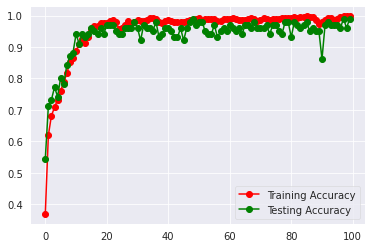

In [60]:
plt.plot(history2.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history2.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

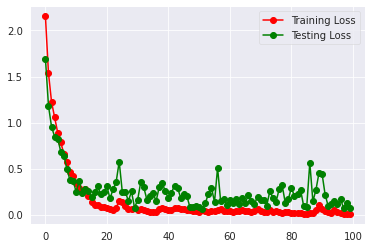

In [61]:
plt.plot(history2.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history2.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [62]:
y_pred  = pemodelan_2.predict(x_test).round()

In [63]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       1.00      1.00      1.00         2
                             ('bcc', ' basal cell carcinoma')       1.00      1.00      1.00         6
                     ('bkl', 'benign keratosis-like lesions')       0.93      1.00      0.96        13
                                     ('df', 'dermatofibroma')       1.00      0.75      0.86         4
                                  ('nv', ' melanocytic nevi')       1.00      1.00      1.00        66
              ('vasc', ' pyogenic granulomas and hemorrhage')       1.00      1.00      1.00         8
                                          ('mel', 'melanoma')       1.00      1.00      1.00         2

                                                    micro avg       0.99      0.99      0.99       101
                                                    macro avg       0.9

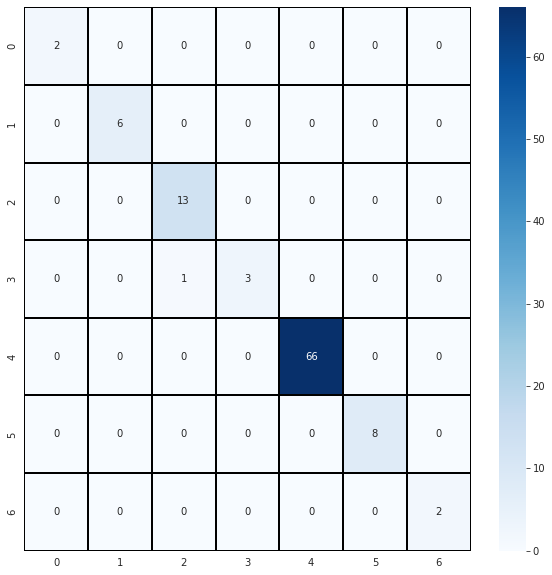

In [65]:
cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

# Predict

In [66]:
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((32,32))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Path : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

data_folder = "/content/drive/MyDrive/ML/Kaggle/data"

model = pemodelan_2

vectors = []
paths = []

for image_path in os.listdir(data_folder):
    image_path_full = os.path.join(data_folder, image_path)
    image_vector = extract_vector(model,image_path_full)
    vectors.append(image_vector)
    paths.append(image_path_full)

vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors, open(vector_file, "wb"))
pickle.dump(paths, open(path_file, "wb"))

Streaming output truncated to the last 5000 lines.
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028339.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028313.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028274.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028309.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028311.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028306.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028279.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028321.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028329.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028383.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028402.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028394.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028378.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028384.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028411.jpg
Path

Dataset :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0027477.jpg


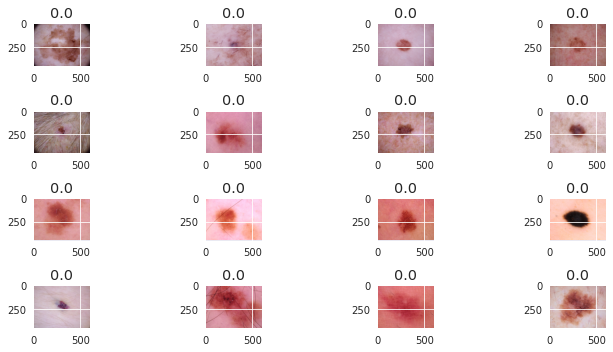

In [67]:
import math
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((32,32))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Dataset : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

search_image = "/content/drive/MyDrive/ML/Kaggle/data/ISIC_0027477.jpg"

model = pemodelan_2

search_vector = extract_vector(model, search_image)

vectors = pickle.load(open("vectors.pkl","rb"))
paths = pickle.load(open("paths.pkl","rb"))

distance = np.linalg.norm(vectors - search_vector, axis=1)

K = 16
ids = np.argsort(distance)[:K]

nearest_image = [(paths[id], distance[id]) for id in ids]

import matplotlib.pyplot as plt

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(10,5))


for id in range(K):
    draw_image = nearest_image[id]
    axes.append(fig.add_subplot(grid_size, grid_size, id+1))

    axes[-1].set_title(draw_image[1])
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()

# Model 3

In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, concatenate, BatchNormalization
from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB5, VGG16
from tensorflow.keras.optimizers import Adam

In [71]:
inputan = (32,32,3)
input_model = Input(shape=inputan)

enb5= EfficientNetB5(include_top=False, weights="imagenet", input_shape=inputan)(input_model)


def pemodelan3(m1):
  model3 = concatenate([m1])
  model3 = GlobalAveragePooling2D()(model3)
  model3 = Flatten(name="flatten")(model3)
  model3 = Dense(2048, activation="relu")(model3)
  model3 = Dropout(0.25)(model3)
  model3 = BatchNormalization()(model3)
  model3 = Dense(1024, activation="relu")(model3)
  model3 = Dropout(0.25)(model3)
  model3 = BatchNormalization()(model3)
  model3 = Dense(7, activation="softmax")(model3)

  return model3

In [72]:
model_3= pemodelan3(enb5)
pemodelan_3 = Model(inputs=input_model, outputs=model_3)
pemodelan_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb5 (Functional)  (None, 1, 1, 2048)       28513527  
                                                                 
 concatenate_3 (Concatenate)  (None, 1, 1, 2048)       0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 2048)              4196352   
                                                           

In [73]:
enb5.trainable = False

In [74]:
import tensorflow as tf
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='./logs/aug')

In [75]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [76]:
!rm -rf ./logs/aug

In [77]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def callback(path):
  checkpoint_callback = ModelCheckpoint(path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
  reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0001, verbose=1)
  callbacks_list = [checkpoint_callback, reduce_callback]
  return callbacks_list

In [78]:
best_model_path = 'model3.h5'
cb=callback(best_model_path)

In [79]:
learning_rate=0.0001
pemodelan_3.compile(optimizer=Adam(lr=learning_rate), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [80]:
history3 = pemodelan_3.fit(x_train ,
                    y_train ,
                    epochs=100 ,
                    batch_size=128,
                    validation_data=(x_test , y_test) ,
                    callbacks=[tensorboard,cb])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 2.2164 - accuracy: 0.3013
Epoch 00001: val_accuracy improved from -inf to 0.05941, saving model to model3.h5
64/64 [==============================] - 83s 542ms/step - loss: 2.2164 - accuracy: 0.3013 - val_loss: 3.4112 - val_accuracy: 0.0594 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 1.5708 - accuracy: 0.5884
Epoch 00002: val_accuracy did not improve from 0.05941
64/64 [==============================] - 22s 337ms/step - loss: 1.5708 - accuracy: 0.5884 - val_loss: 6.9040 - val_accuracy: 0.0198 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 1.2370 - accuracy: 0.6643
Epoch 00003: val_accuracy improved from 0.05941 to 0.21782, saving model to model3.h5
64/64 [==============================] - 29s 449ms/step - loss: 1.2370 - accuracy: 0.6643 - val_loss: 1.7344 - val_accuracy: 0.2178 - lr: 1.0000e-04
Epoch 4/100
64/64 [=========================

In [81]:
pemodelan_3.evaluate(x_test , y_test)

4/4 [==============================] - 2s 298ms/step - loss: 0.8433 - accuracy: 0.8119


[0.8433054089546204, 0.8118811845779419]

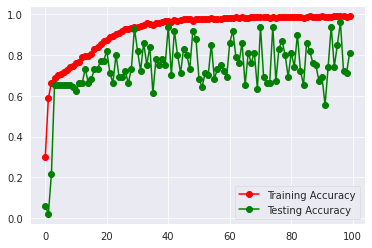

In [82]:
plt.plot(history3.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history3.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

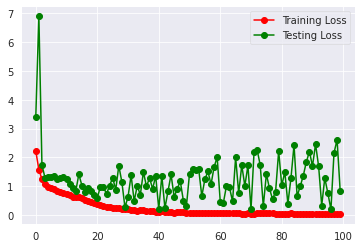

In [84]:
plt.plot(history3.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history3.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [85]:
y_pred  = pemodelan_3.predict(x_test).round()

In [86]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       0.00      0.00      0.00         2
                             ('bcc', ' basal cell carcinoma')       0.62      0.83      0.71         6
                     ('bkl', 'benign keratosis-like lesions')       0.88      0.54      0.67        13
                                     ('df', 'dermatofibroma')       0.75      0.75      0.75         4
                                  ('nv', ' melanocytic nevi')       0.86      0.98      0.92        66
              ('vasc', ' pyogenic granulomas and hemorrhage')       0.67      0.25      0.36         8
                                          ('mel', 'melanoma')       0.00      0.00      0.00         2

                                                    micro avg       0.82      0.81      0.82       101
                                                    macro avg       0.5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


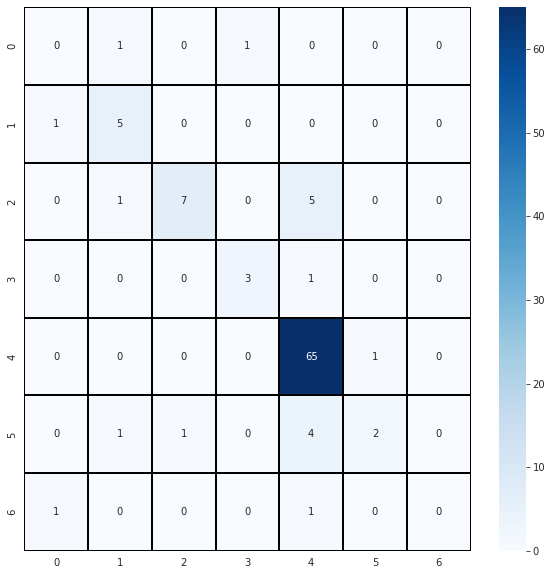

In [88]:
cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

# Predict

In [89]:
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((32,32))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Path : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

data_folder = "/content/drive/MyDrive/ML/Kaggle/data"

model = pemodelan_3

vectors = []
paths = []

for image_path in os.listdir(data_folder):
    image_path_full = os.path.join(data_folder, image_path)
    image_vector = extract_vector(model,image_path_full)
    vectors.append(image_vector)
    paths.append(image_path_full)

vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors, open(vector_file, "wb"))
pickle.dump(paths, open(path_file, "wb"))

Streaming output truncated to the last 5000 lines.
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028339.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028313.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028274.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028309.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028311.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028306.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028279.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028321.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028329.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028383.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028402.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028394.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028378.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028384.jpg
Path :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0028411.jpg
Path

Dataset :  /content/drive/MyDrive/ML/Kaggle/data/ISIC_0024316.jpg


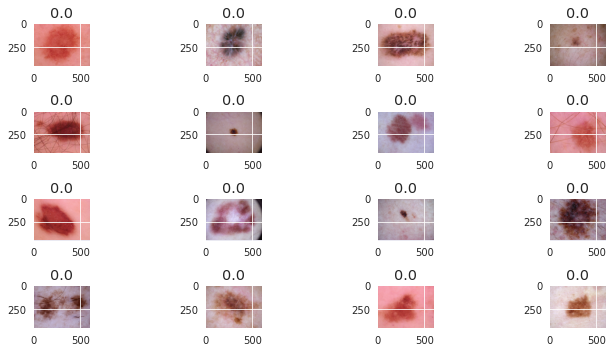

In [90]:
import math
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((32,32))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Dataset : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

search_image = "/content/drive/MyDrive/ML/Kaggle/data/ISIC_0024316.jpg"

model = pemodelan_3

search_vector = extract_vector(model, search_image)

vectors = pickle.load(open("vectors.pkl","rb"))
paths = pickle.load(open("paths.pkl","rb"))

distance = np.linalg.norm(vectors - search_vector, axis=1)

K = 16
ids = np.argsort(distance)[:K]

nearest_image = [(paths[id], distance[id]) for id in ids]

import matplotlib.pyplot as plt

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(10,5))


for id in range(K):
    draw_image = nearest_image[id]
    axes.append(fig.add_subplot(grid_size, grid_size, id+1))

    axes[-1].set_title(draw_image[1])
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()